# 01_exploracion_raw — EDA del EEGMMI (solo MI)

Este notebook realiza **EDA (Exploratory Data Analysis)** sobre los datos crudos en `data/raw/`


## Setup y rutas

Inicializa rutas, crea carpetas de salida para tablas y figuras, fija parámetros del dataset (sujetos a excluir y qué runs corresponden a MI L/R y O/F), y define utilidades básicas para parsear nombres.

In [1]:
# [EDA RAW] Setup y rutas
import os, re, glob, json
import numpy as np
import pandas as pd
import mne
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

# Rutas del proyecto (ajusta si tu notebook está en otra carpeta)
PROJ = Path('..').resolve()
DATA_RAW = PROJ / 'data' / 'raw'
REPORT_FIG = PROJ / 'reports' / 'figures' / '01_EDA_raw'
REPORT_TAB = PROJ / 'reports' / 'tables' / '01_EDA_raw'
REPORT_FIG.mkdir(parents=True, exist_ok=True)
REPORT_TAB.mkdir(parents=True, exist_ok=True)

# Config: sujetos a excluir y runs de MI
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
MI_RUNS_LR = {4, 8, 12}       # Task 2 (imaginería Left/Right)
MI_RUNS_OF = {6, 10, 14}      # Task 4 (imaginería Fists/Feet)

# Mapeo de etiquetas por tipo de run (para interpretación)
LABEL_MAP = {
    'LR': {'T1': 'Left',       'T2': 'Right'},
    'OF': {'T1': 'Both Fists', 'T2': 'Both Feet'},
}

def parse_name(path_or_fname: str):
    """
    Extrae (subject:int, run:int) de nombres tipo 'S001R04.edf'.
    Devuelve (None, None) si no matchea.
    """
    m = re.search(r'S(\d{3})R(\d{2})', os.path.basename(path_or_fname))
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id: int):
    """Clasifica el run en LR (Left/Right), OF (Fists/Feet) o None si no es MI."""
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    return None

print(f'Proyecto en: {PROJ}')


Proyecto en: C:\Users\joelc\Desktop\EEG_Clasificador


## Inventario de archivos

Escanea data/raw, arma un inventario subject–run–edf–event, guarda CSV y muestra un resumen. Esto te dice qué hay disponible y en qué distribución.

In [2]:
# [EDA RAW] Inventario de EDFs
records = []
for subj_dir in sorted([p for p in DATA_RAW.glob('S*') if p.is_dir()]):
    for edf in sorted(subj_dir.glob('*.edf')):
        s, r = parse_name(str(edf))
        if s is None: 
            continue
        evt = edf.with_suffix('.edf.event')
        records.append({
            'subject': s,
            'run': r,
            'edf': str(edf),
            'event': str(evt) if evt.exists() else None,
            'is_mi': run_kind(r) is not None,
            'mi_kind': run_kind(r)
        })

df_files = pd.DataFrame(records).sort_values(['subject','run']).reset_index(drop=True)
display(df_files.head(12))

# Guardar inventario
out_csv = REPORT_TAB / 'eda_files_inventory.csv'
df_files.to_csv(out_csv, index=False)
print(f'Inventario guardado en {out_csv}')

# Sujetos totales (y sujetos “usados” tras exclusión)
subjects_all = sorted(df_files['subject'].unique().tolist())
subjects_used = [s for s in subjects_all if s not in EXCLUDE_SUBJECTS]
print(f"Sujetos totales: {len(subjects_all)} | Sujetos usados: {len(subjects_used)}")
pd.Series(subjects_used, name='subject').to_csv(REPORT_TAB / 'eda_subjects_used.csv', index=False)


,subject,run,edf,event,is_mi,mi_kind
0,1,1,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,False,None
1,1,2,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,False,None
2,1,3,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,False,None
3,1,4,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,True,LR
4,1,5,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,False,None
5,1,6,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,True,OF
6,1,7,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,False,None
7,1,8,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,True,LR
8,1,9,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,False,None
9,1,10,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,C:\Users\joelc\Desktop\EEG_Clasificador\data\r...,True,OF


Inventario guardado en C:\Users\joelc\Desktop\EEG_Clasificador\reports\tables\01_EDA_raw\eda_files_inventory.csv
Sujetos totales: 109 | Sujetos usados: 103


## Conteo de eventos por run y por sujeto

Lee anotaciones por run MI, cuenta T1/T2 mapeados a clases, genera tabla por run y agregados por sujeto. Sirve para ver balance de clases y desbalance entre sujetos.

Contando eventos MI: 100%|██████████| 103/103 [00:11<00:00,  8.80it/s]


,subject,run,kind,Left,Right,Both Fists,Both Feet,Rest
0,1,4,LR,8,7,0,0,15
1,1,6,OF,0,0,7,8,15
2,1,8,LR,8,7,0,0,15
3,1,10,OF,0,0,7,8,15
4,1,12,LR,7,8,0,0,15
5,1,14,OF,0,0,7,8,15
6,2,4,LR,7,8,0,0,15
7,2,6,OF,0,0,8,7,15
8,2,8,LR,8,7,0,0,15
9,2,10,OF,0,0,8,7,15


,count,mean,std,min,25%,50%,75%,max
Left,103.0,22.689320,0.828761,21.0,22.0,23.0,23.0,24.0
Right,103.0,22.310680,0.828761,21.0,22.0,22.0,23.0,24.0
Both Fists,103.0,22.514563,0.916773,21.0,22.0,22.0,23.0,24.0
Both Feet,103.0,22.485437,0.916773,21.0,22.0,23.0,23.0,24.0


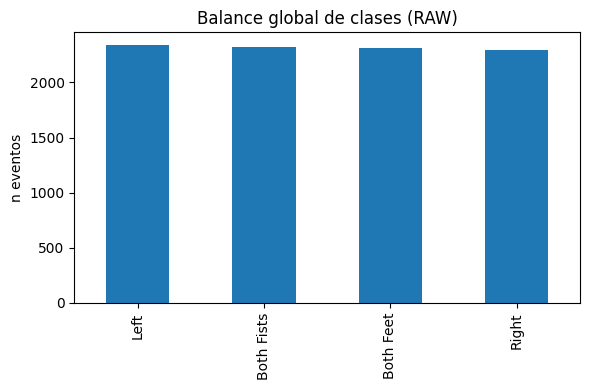

Figura guardada: C:\Users\joelc\Desktop\EEG_Clasificador\reports\figures\01_EDA_raw\raw_class_balance_global.png


In [3]:
# [EDA RAW] Conteo de eventos por run y agregados por sujeto
counts = []
for s in tqdm(subjects_used, desc="Contando eventos MI"):
    subj_dir = DATA_RAW / f'S{s:03d}'
    for edf in sorted(subj_dir.glob('*.edf')):
        ss, rr = parse_name(str(edf))
        kind = run_kind(rr)
        if ss is None or kind is None:
            continue
        try:
            raw = mne.io.read_raw_edf(edf, preload=False, verbose=False)
            events, event_id = mne.events_from_annotations(raw, verbose=False)
        except Exception:
            continue

        inv_map = {v:k for k,v in event_id.items()}
        row = {'subject': ss, 'run': rr, 'kind': kind,
               'Left':0,'Right':0,'Both Fists':0,'Both Feet':0,'Rest':0}
        for e in events:
            code = inv_map.get(e[2], None)
            if code == 'T0':
                row['Rest'] += 1
            elif code == 'T1':
                row[LABEL_MAP[kind]['T1']] += 1
            elif code == 'T2':
                row[LABEL_MAP[kind]['T2']] += 1
        counts.append(row)

df_counts = pd.DataFrame(counts).sort_values(['subject','run'])
display(df_counts.head(10))
df_counts.to_csv(REPORT_TAB / 'eda_event_counts_by_run.csv', index=False)

# Agregados por sujeto (clases MI)
agg_subj = df_counts.groupby('subject')[['Left','Right','Both Fists','Both Feet']].sum()
display(agg_subj.describe().T)
agg_subj.to_csv(REPORT_TAB / 'eda_event_counts_by_subject.csv')

# %% [EDA RAW] Gráfico: balance global de clases MI (barras)
bal_global = df_counts[['Left','Right','Both Fists','Both Feet']].sum().sort_values(ascending=False)
plt.figure(figsize=(6,4))
bal_global.plot(kind='bar')
plt.title('Balance global de clases (RAW)')
plt.ylabel('n eventos')
plt.tight_layout()
out_png = REPORT_FIG / 'raw_class_balance_global.png'
plt.savefig(out_png, dpi=140); plt.show()
print("Figura guardada:", out_png)



## “Ruido” por canal (amplitud)

Mide amplitud cruda por canal (std_uV y p99_uV) en una muestra de sujetos (para no alargar el cómputo). Esto captura qué canales son más “inestables/ruidosos”. Guarda CSV y boxplot.

Amplitud por canal (muestra): 100%|██████████| 10/10 [00:00<00:00, 31.61it/s]


,subject,channel,std_uV,p99_uV
0,1,Fc5.,56.565173,160.00
1,1,Fc3.,54.917808,150.01
2,1,Fc1.,55.584212,154.00
3,1,Fcz.,56.711861,153.00
4,1,Fc2.,52.818553,143.00
5,1,Fc4.,46.340257,129.00
6,1,Fc6.,40.494948,109.00
7,1,C5..,52.393254,142.00
8,1,C3..,52.312384,142.00
9,1,C1..,54.499212,149.00


<Figure size 1200x500 with 0 Axes>

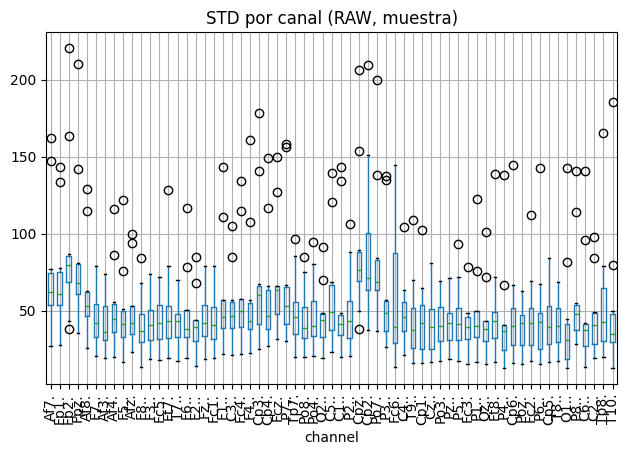

Figura guardada: C:\Users\joelc\Desktop\EEG_Clasificador\reports\figures\01_EDA_raw\raw_channel_std_boxplot.png


In [4]:
# [EDA RAW] Amplitud por canal (std y p99) en muestra de sujetos
sample_subjects = subjects_used[:10]  # ajusta el tamaño de muestra
stats = []

for s in tqdm(sample_subjects, desc="Amplitud por canal (muestra)"):
    subj_dir = DATA_RAW / f'S{s:03d}'
    # usa un run MI típico si existe (LR R04 como primera opción)
    cand = [subj_dir / f'S{s:03d}R{r:02d}.edf' for r in [4,6,8,10,12,14]]
    edf = next((p for p in cand if p.exists()), None)
    if edf is None:
        continue

    raw = mne.io.read_raw_edf(edf, preload=True, verbose=False)
    data = raw.get_data() * 1e6  # a microvoltios
    ch_names = raw.ch_names

    for i, ch in enumerate(ch_names[:-1]):  # evita canal de anotaciones si hubiera
        x = data[i]
        stats.append({
            'subject': s, 'channel': ch,
            'std_uV':   float(np.std(x)),
            'p99_uV':   float(np.percentile(np.abs(x), 99)),
        })

df_ch = pd.DataFrame(stats)
df_ch.to_csv(REPORT_TAB / 'eda_channel_stats_sample.csv', index=False)
display(df_ch.head(10))

# Boxplot de std por canal (ordenado por mediana)
plt.figure(figsize=(12,5))
order = df_ch.groupby('channel')['std_uV'].median().sort_values(ascending=False).index
df_ch.boxplot(column='std_uV', by='channel', positions=np.arange(len(order)))
plt.xticks(range(len(order)), order, rotation=90)
plt.title('STD por canal (RAW, muestra)'); plt.suptitle('')
plt.tight_layout()
out_png = REPORT_FIG / 'raw_channel_std_boxplot.png'
plt.savefig(out_png, dpi=150); plt.show()
print('Figura guardada:', out_png)


## PSD en C3/Cz/C4 (ejemplo de sujeto)

Normaliza nombres de canal, asigna montaje estándar (si se puede) y dibuja la PSD promedio 1–60 Hz de C3/Cz/C4. Es la “foto” espectral pre-proc en corte motor.

In [5]:
# [EDA RAW] PSD en canales motores (C3, Cz, C4) para un sujeto ejemplo
def normalize_name(ch: str) -> str:
    """
    Normaliza nombres típicos a estándar 10-20:
    - quita 'EEG', 'REF', espacios, signos
    - corrige C03->C3, etc.
    - CZ->Cz, PZ->Pz, etc.
    """
    s = ch.upper()
    for token in ['EEG','REF']:
        s = s.replace(token, '')
    s = re.sub(r'[^A-Z0-9]+', '', s)
    s = re.sub(r'([A-Z])0([0-9])', r'\1\2', s)
    if s.endswith('Z'):
        s = s[:-1] + 'z'
    aliases = {'FCZ':'Fcz','CPZ':'Cpz','POZ':'Poz','OZ':'Oz','PZ':'Pz','CZ':'Cz','FZ':'Fz','TPZ':'Tpz'}
    if s in aliases: return aliases[s]
    if len(s) >= 2 and s[1].isdigit(): return s[0] + s[1:]
    return s[0] + s[1:].lower() if s else ch

def plot_psd_motors_example(subject_id: int):
    subj_dir = DATA_RAW / f'S{subject_id:03d}'
    cand = [subj_dir / f'S{subject_id:03d}R{r:02d}.edf' for r in [4,6,8,10,12,14]]
    edf = next((p for p in cand if p.exists()), None)
    if edf is None:
        print(f"Sin EDF MI para S{subject_id:03d}")
        return
    raw = mne.io.read_raw_edf(edf, preload=True, verbose=False)
    rename = {ch: normalize_name(ch) for ch in raw.ch_names}
    raw.rename_channels(rename)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    picks = mne.pick_channels(raw.ch_names, include=['C3','Cz','C4'], ordered=False)
    if len(picks)==0:
        print("No se hallaron C3/Cz/C4 de forma confiable.")
        return
    fig = raw.plot_psd(fmin=1, fmax=60, picks=picks, average=True, show=False)
    if isinstance(fig, tuple):
        fig = fig[0]
    out_png = REPORT_FIG / f'raw_psd_subject_{subject_id:03d}_C3CzC4.png'
    fig.savefig(out_png, dpi=150); plt.close(fig)
    print("PSD guardada:", out_png)

# Ejemplo: primer sujeto disponible
if subjects_used:
    plot_psd_motors_example(subjects_used[0])


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
PSD guardada: C:\Users\joelc\Desktop\EEG_Clasificador\reports\figures\01_EDA_raw\raw_psd_subject_001_C3CzC4.png


## Métricas RAW por sujeto (para comparar luego)

Construye un conjunto de métricas comparables por sujeto (se guardan en metrics_raw_subject.csv). Incluye:

- n_runs_mi: número de runs MI disponibles
- n_events_*: conteos por clase
- std_uV_median, p99_uV_median: indicadores de amplitud/ruido crudo (muestra)
- silhouette_logvar_raw: separabilidad cruda usando log-var por canal en C3/Cz/C4 (si es posible), agregando runs LR+OF

Estas métricas son las que luego compararemos contra el post.

In [7]:
# [EDA RAW] Métricas por sujeto (tabla para comparación con post)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score

def find_motor_like(ch_names):
    """Devuelve índices aproximados de C3/Cz/C4 (búsqueda tolerante)."""
    up = [c.upper() for c in ch_names]
    idx = []
    for token in ['C3','CZ','C4']:
        hit = next((i for i, name in enumerate(up) if token in name), None)
        if hit is not None:
            idx.append(hit)
    return sorted(set(idx))

def epochs_from_edf(edf_path, tmin=0.5, tmax=4.5):
    """Crea epochs simples (T1/T2) filtrando 8–30 Hz para extraer log-var cruda."""
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    raw.filter(l_freq=8, h_freq=30, picks='eeg', method='iir', verbose=False)
    events, event_id = mne.events_from_annotations(raw, verbose=False)

    # Normaliza claves de event_id y conserva T1/T2 si están
    clean_eid = {}
    for k, v in event_id.items():
        k2 = str(k).strip()
        try:
            clean_eid[k2] = int(v)
        except Exception:
            pass
    keep_keys = [k for k in ['T1','T2'] if k in clean_eid]
    if len(keep_keys) < 2:
        # si no hay T1/T2 claros, toma dos códigos más frecuentes del registro
        codes, counts = np.unique(events[:,2], return_counts=True)
        order = codes[np.argsort(counts)[::-1]]
        if len(order) >= 2:
            clean_eid = {'T1': int(order[0]), 'T2': int(order[1])}
        else:
            return None
    else:
        clean_eid = {k: clean_eid[k] for k in keep_keys}

    epochs = mne.Epochs(raw, events, event_id=clean_eid,
                        tmin=tmin, tmax=tmax, baseline=None,
                        picks='eeg', preload=True, verbose=False)
    return epochs

def logvar(arr):
    """Log-var por canal: (n_epochs, n_channels, n_times) -> (n_epochs, n_channels)."""
    return np.log(np.var(arr, axis=-1) + 1e-8)

# Amplitud por sujeto (desde la muestra calculada en df_ch)
amp_by_subj = df_ch.groupby('subject').agg(std_uV_median=('std_uV','median'),
                                           p99_uV_median=('p99_uV','median')).reset_index()

rows = []
for s in subjects_used:
    # runs MI disponibles
    runs_s = df_files.query("subject == @s and is_mi == True").sort_values('run')
    n_runs_mi = len(runs_s)

    # conteos agregados por sujeto
    cnt = df_counts[df_counts['subject']==s][['Left','Right','Both Fists','Both Feet']].sum()
    n_L = int(cnt.get('Left', 0)); n_R = int(cnt.get('Right', 0))
    n_F = int(cnt.get('Both Fists', 0)); n_Feet = int(cnt.get('Both Feet', 0))

    # separabilidad cruda (silhouette en log-var motores, si hay datos)
    X_list, y_list = [], []
    for _, row in runs_s.iterrows():
        edf = Path(row['edf'])
        kind = row['mi_kind']  # LR u OF
        ep = epochs_from_edf(edf)
        if ep is None or len(ep)==0:
            continue
        motor_idx = find_motor_like(ep.ch_names)
        picks = motor_idx if motor_idx else 'eeg'
        data = ep.get_data(picks=picks)
        feats = logvar(data)
        # mapear T1/T2 a clases legibles según el tipo de run
        if 'T1' in ep.event_id:
            X_list.append(feats[ep.events[:,2]==ep.event_id['T1']])
            y_list += [LABEL_MAP[kind]['T1']] * X_list[-1].shape[0]
        if 'T2' in ep.event_id:
            X_list.append(feats[ep.events[:,2]==ep.event_id['T2']])
            y_list += [LABEL_MAP[kind]['T2']] * X_list[-1].shape[0]

    if X_list:
        X = np.vstack(X_list)
        y = np.array(y_list)
        if len(np.unique(y)) >= 2 and X.shape[0] > 10:
            Xz = StandardScaler().fit_transform(X)
            try:
                sil = float(silhouette_score(Xz, y, metric='euclidean'))
            except Exception:
                sil = np.nan
        else:
            sil = np.nan
    else:
        sil = np.nan

    # amplitud/ruido mediano desde df_ch (si el sujeto estuvo en la muestra)
    amp_row = amp_by_subj[amp_by_subj['subject']==s]
    std_med = float(amp_row['std_uV_median'].iloc[0]) if not amp_row.empty else np.nan
    p99_med = float(amp_row['p99_uV_median'].iloc[0]) if not amp_row.empty else np.nan

    rows.append(dict(
        subject=s,
        n_runs_mi=n_runs_mi,
        n_events_left=n_L,
        n_events_right=n_R,
        n_events_fists=n_F,
        n_events_feet=n_Feet,
        std_uV_median=std_med,
        p99_uV_median=p99_med,
        silhouette_logvar_raw=sil
    ))

df_metrics_raw = pd.DataFrame(rows).sort_values('subject')
display(df_metrics_raw.head(10))
out_metrics = REPORT_TAB / 'metrics_raw_subject.csv'
df_metrics_raw.to_csv(out_metrics, index=False)
print("Métricas RAW por sujeto guardadas en:", out_metrics)


,subject,n_runs_mi,n_events_left,n_events_right,n_events_fists,n_events_feet,std_uV_median,p99_uV_median,silhouette_logvar_raw
0,1,6,23,22,21,24,52.197511,142.00,-0.003047
1,2,6,23,22,24,21,20.946377,62.00,-0.133904
2,3,6,23,22,21,24,52.387219,142.01,-0.091233
3,4,6,23,22,22,23,36.402239,102.00,-0.097152
4,5,6,21,24,23,22,43.878352,113.00,-0.062833
5,6,6,24,21,22,23,19.438997,57.00,-0.127829
6,7,6,23,22,22,23,40.988794,102.00,-0.076580
7,8,6,22,23,23,22,32.112222,90.00,-0.128992
8,9,6,24,21,23,22,84.088265,243.00,-0.086518
9,10,6,24,21,23,22,114.736314,317.21,-0.149744


Métricas RAW por sujeto guardadas en: C:\Users\joelc\Desktop\EEG_Clasificador\reports\tables\01_EDA_raw\metrics_raw_subject.csv


## t-SNE 2D crudo (visual) para un sujeto

Genera un t-SNE 2D de log-var por canal, idealmente usando C3/Cz/C4, combinando un run LR y uno OF del mismo sujeto.

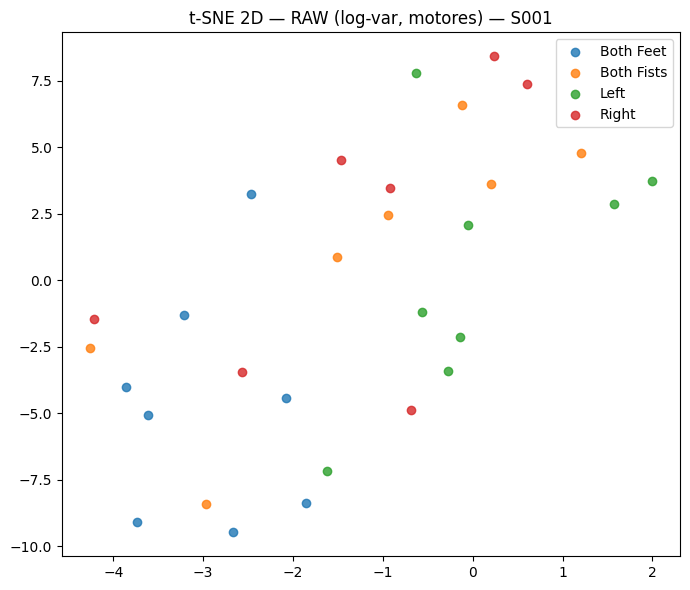

t-SNE RAW guardado en: C:\Users\joelc\Desktop\EEG_Clasificador\reports\figures\01_EDA_raw\raw_tsne2d_logvar_4cl_motor_S001.png


In [8]:
# [EDA RAW] t-SNE 2D (visual) en un sujeto ejemplo
from sklearn.manifold import TSNE

def first_available(subj, candidates):
    base = DATA_RAW / f"S{subj:03d}"
    for r in candidates:
        p = base / f"S{subj:03d}R{r:02d}.edf"
        if p.exists():
            return p
    return None

def tsne_raw_example(subject_id: int, use_motor_only=True, n_per_class=120, random_state=42):
    edf_lr = first_available(subject_id, [4,8,12])   # LR
    edf_of = first_available(subject_id, [6,10,14])  # OF
    if edf_lr is None or edf_of is None:
        print("No hay par de runs MI (LR y OF) para t-SNE.")
        return

    def ep_from(edf):
        ep = epochs_from_edf(edf)
        if ep is None or len(ep)==0:
            raise RuntimeError(f"Epochs vacíos en {edf.name}")
        return ep

    ep_lr = ep_from(edf_lr)
    ep_of = ep_from(edf_of)

    motor_lr = find_motor_like(ep_lr.ch_names)
    motor_of = find_motor_like(ep_of.ch_names)

    if use_motor_only and (not motor_lr or not motor_of):
        print("No se hallaron motores consistentes; usando todos los EEG.")
        use_motor_only = False

    picks_lr = motor_lr if use_motor_only else 'eeg'
    picks_of = motor_of if use_motor_only else 'eeg'

    X_list, y_list = [], []
    if 'T1' in ep_lr.event_id:
        X_list.append(logvar(ep_lr['T1'][:n_per_class].get_data(picks=picks_lr)))
        y_list += ['Left'] * X_list[-1].shape[0]
    if 'T2' in ep_lr.event_id:
        X_list.append(logvar(ep_lr['T2'][:n_per_class].get_data(picks=picks_lr)))
        y_list += ['Right'] * X_list[-1].shape[0]
    if 'T1' in ep_of.event_id:
        X_list.append(logvar(ep_of['T1'][:n_per_class].get_data(picks=picks_of)))
        y_list += ['Both Fists'] * X_list[-1].shape[0]
    if 'T2' in ep_of.event_id:
        X_list.append(logvar(ep_of['T2'][:n_per_class].get_data(picks=picks_of)))
        y_list += ['Both Feet'] * X_list[-1].shape[0]

    if not X_list:
        print("Sin features para t-SNE.")
        return

    X = np.vstack(X_list)
    y = np.array(y_list)
    Xz = StandardScaler().fit_transform(X)
    perp = max(5, min(30, Xz.shape[0] // 3))
    Z2 = TSNE(n_components=2, init="pca", perplexity=perp,
              learning_rate="auto", max_iter=1500, random_state=random_state).fit_transform(Xz)

    plt.figure(figsize=(7,6))
    for lbl in np.unique(y):
        sel = (y == lbl)
        plt.scatter(Z2[sel,0], Z2[sel,1], alpha=0.8, label=lbl)
    plt.title(f"t-SNE 2D — RAW (log-var, {'motores' if use_motor_only else 'todos'}) — S{subject_id:03d}")
    plt.legend()
    plt.tight_layout()
    out_png = REPORT_FIG / f"raw_tsne2d_logvar_4cl_{'motor' if use_motor_only else 'all'}_S{subject_id:03d}.png"
    plt.savefig(out_png, dpi=150); plt.show()
    print("t-SNE RAW guardado en:", out_png)

# Ejecuta para el primer sujeto disponible
if subjects_used:
    tsne_raw_example(subjects_used[0], use_motor_only=True)
